# Exploratory Data Analysing Using Youtube Video Data from My Favourite Indonesian Comedian Channels

### Rizky Nurhidayat | 26/09/2023

## Aims and objectives

Within this project, I would like to explore the following:

- Getting to know Youtube API and how to obtain video data.
- Analyzing video data and verify different common "myths" about what makes a video do well on Youtube, for example:
    - Does the number of likes and comments matter for a video to get more views?
    - Does the video duration matter for views and interaction (likes/ comments)?
    - Does title length matter for views?
    - How many tags do good performing videos have? What are the common tags among these videos?
    - Across all the creators I take into consideration, how often do they upload new videos? On which days in the week?
- Explore the trending topics using NLP techniques
    - Which popular topics are being covered in the videos (e.g. using wordcloud for video titles)?
    - Which questions are being asked in the comment sections in the videos

## Steps of the project
1. Obtain video meta data via Youtube API (this includes several small steps: create a developer key, request data and transform the responses into a usable data format)
2. Prepocess data and engineer additional features for analysis
3. Exploratory data analysis
4. Conclusions

In [1]:
import pandas as pd
import numpy as np
from dateutil import parser
import isodate

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

# Google API
from googleapiclient.discovery import build

In [ ]:
# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

## 1. Data Collection

I created my own dataset using the Google Youtube Data API version 3.0.

First, I created a project on Google Developers Console, then requested an authorization credential (API key). Afterwards, I enabled Youtube API for my application, so that I can send API requests to Youtube API services. Then, I went on Youtube and checked the channel ID of each of the channels that I would like to include in my research scope (using their URLs). Then I created the functions for getting the channel statistics via the API.

In [3]:
api_key = 'My_API_Key'

In [4]:
channel_ids = ['UC0rzsIrAxF4kCsALP6J2EsA', #Raditya Dika
               'UCh1SzxJAH9B5nZDYYa42UqQ', #Pandji Pragiwaksono
               'UCnrlTmgYcvQLa-m02kLf8gQ', #Dzawin Nur
               'UCHKF275XLmJdmHgTLIxb8lA', #Kemal Palevi
               #more channels here
              ]

In [5]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
api_service_name, api_version, developerKey=api_key)

In [6]:
def get_channel_stats(youtube, channel_ids):
    """
    Get channel statistics: title, subscriber count, view count, video count, upload playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    channels_ids: list of channel IDs
    
    Returns:
    Dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist
    
    """
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):
    """
    Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist
    
    """
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:5]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)

### Get channel statistics

In [8]:
channel_data = get_channel_stats(youtube, channel_ids)
channel_data

,channelName,subscribers,views,totalVideos,playlistId
0,Raditya Dika,10100000,2127146332,1920,UU0rzsIrAxF4kCsALP6J2EsA
1,Dzawin Nur,2280000,305181215,286,UUnrlTmgYcvQLa-m02kLf8gQ
2,Kemal Palevi,1160000,150774872,369,UUHKF275XLmJdmHgTLIxb8lA
3,Pandji Pragiwaksono,1190000,250309600,2077,UUh1SzxJAH9B5nZDYYa42UqQ


In [9]:
# Convert count columns to numeric columns
numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_data[numeric_cols] = channel_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

Let's take a look at the number of subscribers per channel to have a view of how popular the channels are when compared with one another.

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

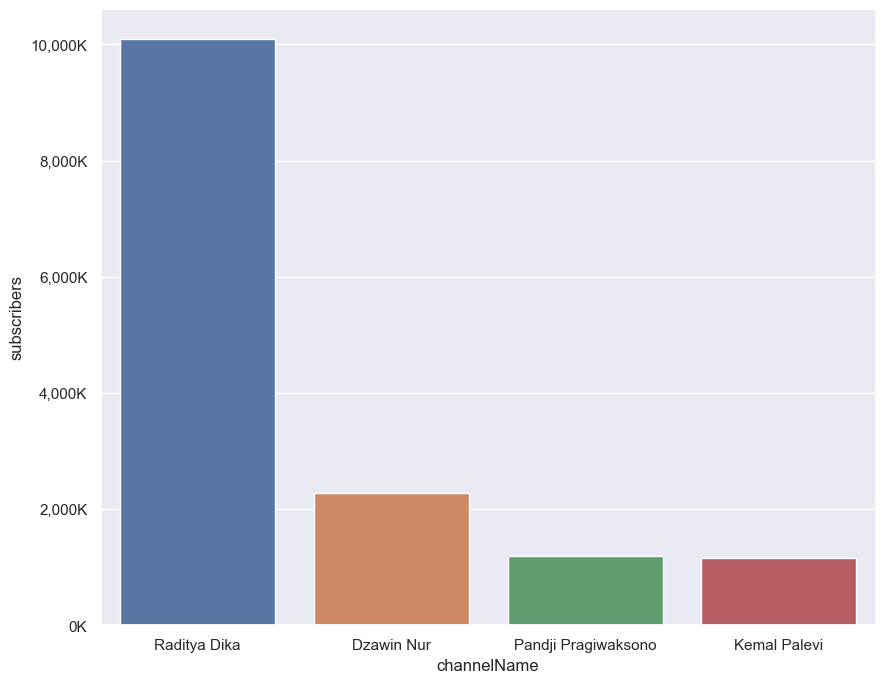

In [12]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channelName', y='subscribers', data=channel_data.sort_values('subscribers', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels())

Next, we will look at the rank considering the total number of views of the channels. The rank is fairly similar to the subscriber count rank.

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

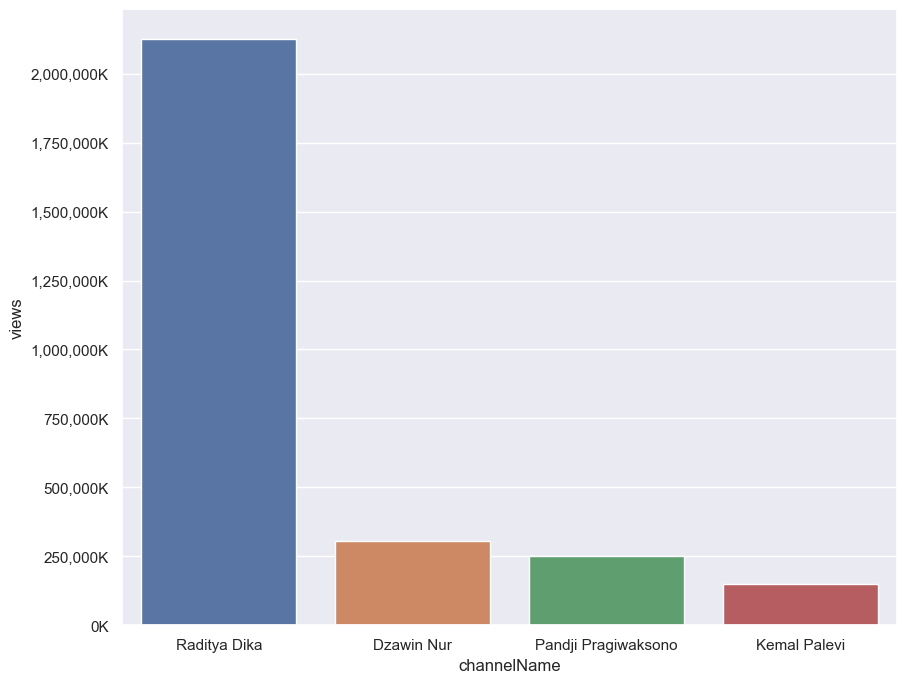

In [13]:
ax = sns.barplot(x='channelName', y='views', data=channel_data.sort_values('views', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels())

### Get video statistics for all the channels

In [ ]:
# Initialize DataFrames
video_data_list = []
comments_data_list = []

for c in channel_data['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_data.loc[channel_data['channelName'] == c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # Get video data
    video_data = get_video_details(youtube, video_ids)
    video_data_list.append(video_data)
    
    # Get comment data
    comments_data = get_comments_in_videos(youtube, video_ids)
    comments_data_list.append(comments_data)

# Combine lists into DataFrames
video_df = pd.concat(video_data_list, ignore_index=True)
comments_df = pd.concat(comments_data_list, ignore_index=True)

# Now you have the final video_df and comments_df DataFrames


In [ ]:
video_df.to_csv('video_data.csv')
comments_df.to_csv('comments_data.csv')

In [15]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,kTgmhXBhuVQ,Kemal Palevi,SOTOY BANGET NIH ORANG DUA SOAL PERCINTAAN CKC...,"Di #bertahandiindustri episode kali ini, gue k...","['Kemal Palevi', 'Stand Up Comedy', 'Sneakers'...",2023-09-25T09:33:22Z,6579,183,NaN,23.0,PT58M13S,hd,False
1,K_R9k2UHoXQ,Kemal Palevi,UFC BRUTAL! KAMI SUKA! #PodcastDuelUFC,Selamat datang di Podcast Duel UFC! Dan di epi...,"['Kemal Palevi', 'Stand Up Comedy', 'Sneakers'...",2023-09-22T05:28:35Z,9561,346,NaN,116.0,PT30M39S,hd,False
2,MeoR0PVLkiw,Kemal Palevi,KALAU MAU BISNIS MAKANAN JANGAN ASAL JIPLAK DO...,"Kata Chef Arnold, kalau mau bikin bisnis makan...","['Kemal Palevi', 'Stand Up Comedy', 'Sneakers'...",2023-09-20T08:01:44Z,21584,518,NaN,45.0,PT51M56S,hd,False
3,a74NjKOVaAg,Kemal Palevi,BERANGKATIN CREW KE BELANDA NONTON BLINK 182 D...,Gimana sih cara bikin podcast lucu ala Podcast...,"['Kemal Palevi', 'Stand Up Comedy', 'Sneakers'...",2023-09-18T08:32:00Z,40399,903,NaN,173.0,PT1H7M5S,hd,False
4,JjyF7zW45WM,Kemal Palevi,APOS PRO PLAYER RENTAL PS YANG NGALAHIN GE SAN...,"Bisa-bisanya Ge Pamungkas, yang fans berat UFC...","['Kemal Palevi', 'Stand Up Comedy', 'Sneakers'...",2023-09-15T08:26:21Z,2698,89,NaN,11.0,PT16M21S,hd,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4379,-19nHp-udR0,Dzawin Nur,Stand Up Comedy Dzawin - Nggak Percaya Kesurupan,ini adalah materi lama stand up comedy gua yan...,"['stand up comedy', 'stand up comedy indonesia...",2016-05-18T15:36:31Z,299575,7573,NaN,114.0,PT5M45S,hd,False
4380,Ev--MxR9UHw,Dzawin Nur,Stand Up Comedy Dzawin - Setan Extra Joss,ini adalah materi lama stand up comedy gua yan...,"['stand up comedy', 'stand up show', 'stand up...",2016-05-16T09:55:51Z,348154,7491,NaN,143.0,PT4M31S,hd,False
4381,zcKQ8p2BnQw,Dzawin Nur,Stand Up Comedy Dzawin - Suara Setan Terseram,ini adalah materi lama stand up comedy gua yan...,"['stand up comedy', 'stand up', 'stand up show...",2016-05-16T09:45:34Z,273660,6688,NaN,110.0,PT4M3S,hd,False
4382,EWAWUIGGt00,Dzawin Nur,Stand Up Comedy Dzawin - Setan Pesantren,ini adalah materi lama stand up comedy gua yan...,"['stand up comedy', 'comedy', 'stand up', 'dza...",2016-05-16T08:57:35Z,566625,15475,NaN,398.0,PT5M19S,hd,False


In [16]:
comments_df

,video_id,comments
0,kTgmhXBhuVQ,"['diliat-liat Firda cakep ya:)', 'Bang kemal u..."
1,K_R9k2UHoXQ,"['Bang bahas UFC 294 dong', 'Terimakasih bang ..."
2,MeoR0PVLkiw,"['bang kemal, kayanya episode sekarang kekecil..."
3,a74NjKOVaAg,"['🍍🍍', 'Bapak2 diabetes satu ini luar biasa ko..."
4,JjyF7zW45WM,"['Jakarta (Jajak Karya Orang Lain)', 'wah seru..."
...,...,...
4362,-19nHp-udR0,['Salah satu idola gue yg sangatsangat mencerd...
4363,Ev--MxR9UHw,"['Tau banget cerita ini, kamar mandi gedung me..."
4364,zcKQ8p2BnQw,"['Bang zawin ajak Sony Wakwaw naik gunung', 'i..."
4365,EWAWUIGGt00,['Ga terasa udah 8 tahun yang lalu video ini d...


## 2. Preprocessing & Feature engineering

To be able to make use of the data for analysis, we need to perform a few pre-processing steps.

### Check for empty values

In [17]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description        True
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount       True
duration          False
definition        False
caption           False
dtype: bool

There's no strange dates in the publish date column, videos were published between 2016 and 2023.

In [18]:
video_df.publishedAt.sort_values().value_counts()

publishedAt
2016-01-02T03:00:00Z    8
2016-05-20T12:00:01Z    5
2016-01-02T03:00:01Z    3
2016-05-20T12:00:00Z    2
2016-05-20T12:00:02Z    2
                       ..
2019-08-01T00:58:14Z    1
2019-08-01T02:00:07Z    1
2019-08-02T01:32:28Z    1
2019-08-02T11:49:09Z    1
2023-09-26T04:21:34Z    1
Name: count, Length: 4369, dtype: int64

Next, we need to check if the data type of the columns are correct. I have checked the data types and indeed some count columns such as view count and comment count are currently not in correct data type. In this step, we convert these count columns into integer.

In [19]:
cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[cols] = video_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

### Enriching data

In [20]:
# Create publish day (in the week) column
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['publishedDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [21]:
# convert duration to seconds
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [22]:
# Add number of tags
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(str(x).split(',')) if isinstance(x, str) else 0)

In [23]:
# Comments and likes per 1000 view ratio
video_df['likeRatio'] = video_df['likeCount']/ video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount']/ video_df['viewCount'] * 1000

In [24]:
# Title character length
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))

In [25]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishedDayName,durationSecs,tagsCount,likeRatio,commentRatio,titleLength
0,kTgmhXBhuVQ,Kemal Palevi,SOTOY BANGET NIH ORANG DUA SOAL PERCINTAAN CKC...,"Di #bertahandiindustri episode kali ini, gue k...","['Kemal Palevi', 'Stand Up Comedy', 'Sneakers'...",2023-09-25 09:33:22+00:00,6579.0,183.0,NaN,23.0,PT58M13S,hd,False,Monday,0 days 00:58:13,30,27.815777,3.495972,62
1,K_R9k2UHoXQ,Kemal Palevi,UFC BRUTAL! KAMI SUKA! #PodcastDuelUFC,Selamat datang di Podcast Duel UFC! Dan di epi...,"['Kemal Palevi', 'Stand Up Comedy', 'Sneakers'...",2023-09-22 05:28:35+00:00,9561.0,346.0,NaN,116.0,PT30M39S,hd,False,Friday,0 days 00:30:39,32,36.188683,12.132622,38
2,MeoR0PVLkiw,Kemal Palevi,KALAU MAU BISNIS MAKANAN JANGAN ASAL JIPLAK DO...,"Kata Chef Arnold, kalau mau bikin bisnis makan...","['Kemal Palevi', 'Stand Up Comedy', 'Sneakers'...",2023-09-20 08:01:44+00:00,21584.0,518.0,NaN,45.0,PT51M56S,hd,False,Wednesday,0 days 00:51:56,32,23.999259,2.084878,63
3,a74NjKOVaAg,Kemal Palevi,BERANGKATIN CREW KE BELANDA NONTON BLINK 182 D...,Gimana sih cara bikin podcast lucu ala Podcast...,"['Kemal Palevi', 'Stand Up Comedy', 'Sneakers'...",2023-09-18 08:32:00+00:00,40399.0,903.0,NaN,173.0,PT1H7M5S,hd,False,Monday,0 days 01:07:05,32,22.352038,4.282284,81
4,JjyF7zW45WM,Kemal Palevi,APOS PRO PLAYER RENTAL PS YANG NGALAHIN GE SAN...,"Bisa-bisanya Ge Pamungkas, yang fans berat UFC...","['Kemal Palevi', 'Stand Up Comedy', 'Sneakers'...",2023-09-15 08:26:21+00:00,2698.0,89.0,NaN,11.0,PT16M21S,hd,False,Friday,0 days 00:16:21,35,32.987398,4.077094,71


## 3. Exploratory Analysis

### Views distribution per channel

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

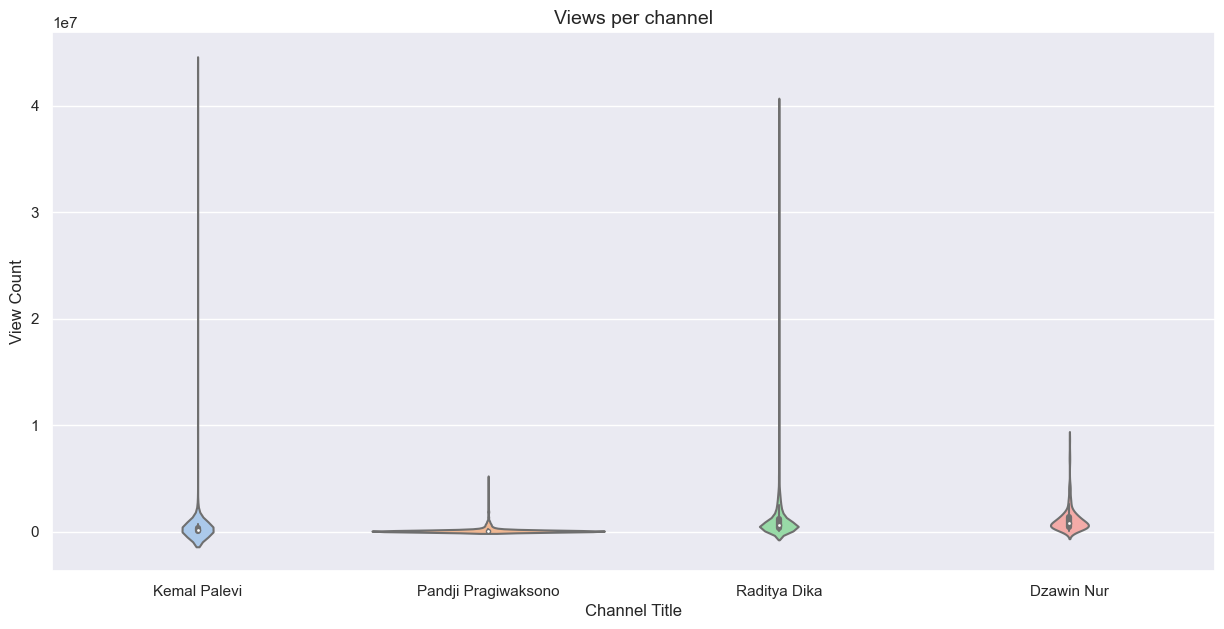

In [26]:
plt.figure(figsize=(15, 7))
sns.violinplot(x=video_df['channelTitle'], y=video_df['viewCount'], palette='pastel')
plt.title('Views per channel', fontsize=14)
plt.xlabel('Channel Title', fontsize=12)
plt.ylabel('View Count', fontsize=12)
plt.show()

### Does the number of likes and comments matter for a video to get more views?

Firstly, I would like to check if comments and likes do correlate with how many views a video would get. In the plots below, it can be observed that the number of views and number of comments/ likes strongly correlated with each other. The number of likes seems to suggest stronger correlation than the number of comments. However, this is expected as the more people watching a video, the more likely this video will get comments and likes. To correct for this factor, we will plot these relationships again using the comments per 1000 view and likes per 1000 view ratios.

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

<Axes: xlabel='likeCount', ylabel='viewCount'>

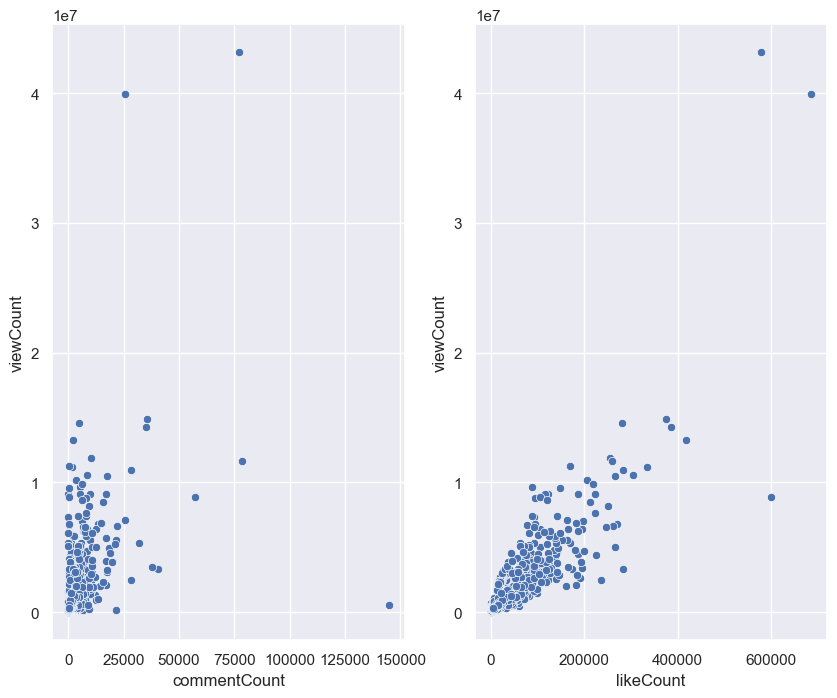

In [26]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1])

Now we will take a look at the correlation if we look at the comment ratio and like ratio instead of the absolute number.

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

<Axes: xlabel='likeRatio', ylabel='viewCount'>

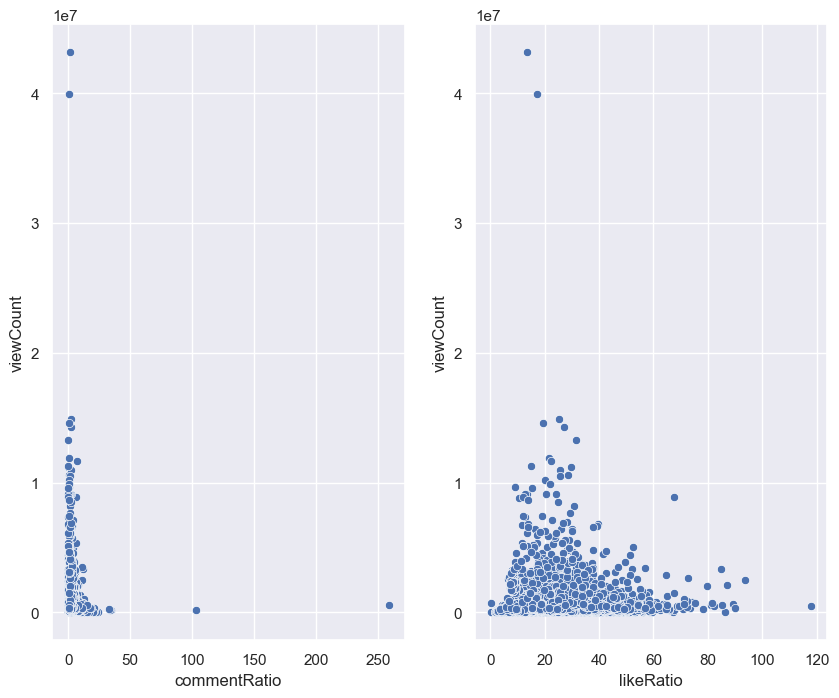

In [27]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[1])

After correcting for the absolute number of views, it turns out that the correlation is much less clear. The comment-view relationship seems to completely disappear: a lot of videos have millions of views and very few comments, while some videos have very few views have better interaction. However, it is understandable that comments take more effort than views and likes, and normally comments would die off when the video gets older.

As for like-view relatioship, we can still see some positive correlation between views and like ratio (though very subtle), which means that the more views a video has, the more people would hit the like button! This seems to support the idea of social proof, which means that people tend to like better the products that are already liked by many other people.

#### Does the video duration matter for views and interaction (likes/ comments)?

As can be seen in the histogram below, most videos are between 300 to 1200 seconds, which is about 5 to 20 minutes. Here I have to limit the duration to 10,000 because of some really long videos (potentially streaming videos). 

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


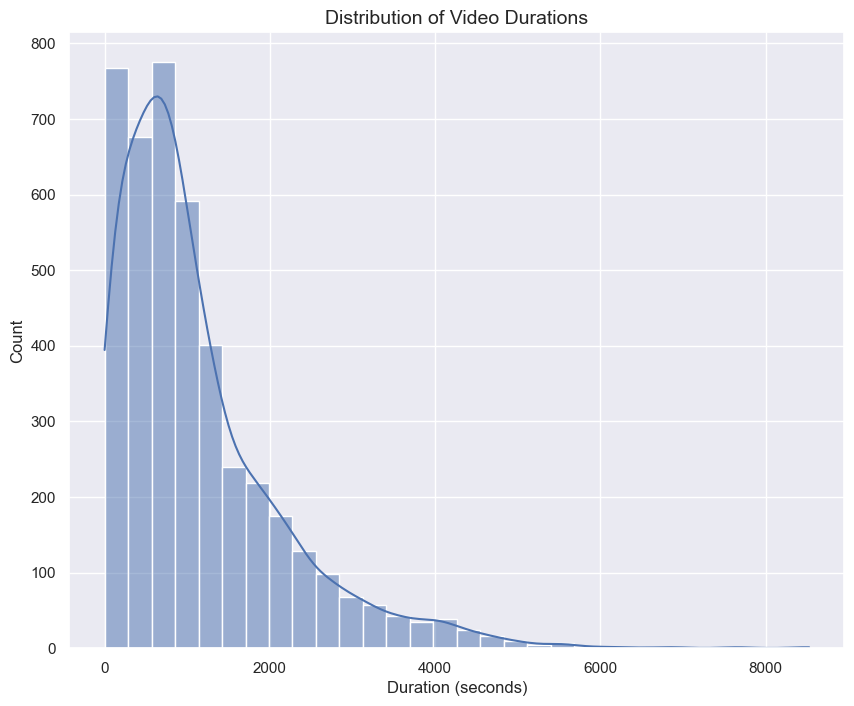

In [28]:
video_df['durationSecs'] = video_df['durationSecs'].dt.total_seconds().astype(int)
filtered_data = video_df[video_df['durationSecs'] < 10000]
sns.histplot(data=filtered_data, x="durationSecs", bins=30, kde=True)
plt.title('Distribution of Video Durations', fontsize=14)
plt.xlabel('Duration (seconds)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

Now we plot the duration against comment count and like count. It can be seen that actually shorter videos tend to get more likes and comments than very long videos.

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtyp

<Axes: xlabel='durationSecs', ylabel='likeCount'>

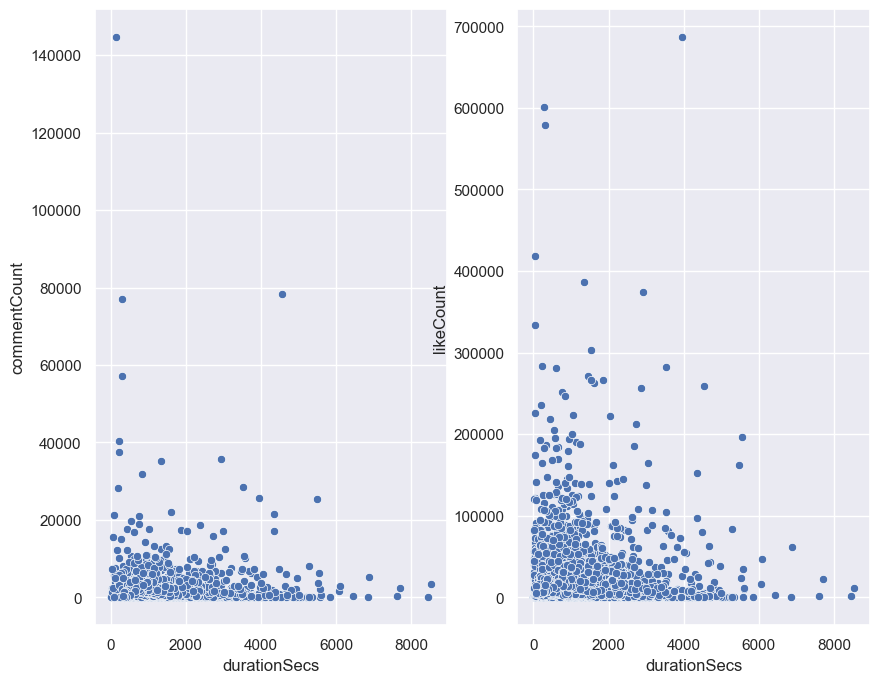

In [29]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

### Does title length matter for views?

There is no clear relationship between title length and views as seen the scatterplot below, but most-viewed videos tend to have average title length of 20-70 characters.

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='titleLength', ylabel='viewCount'>

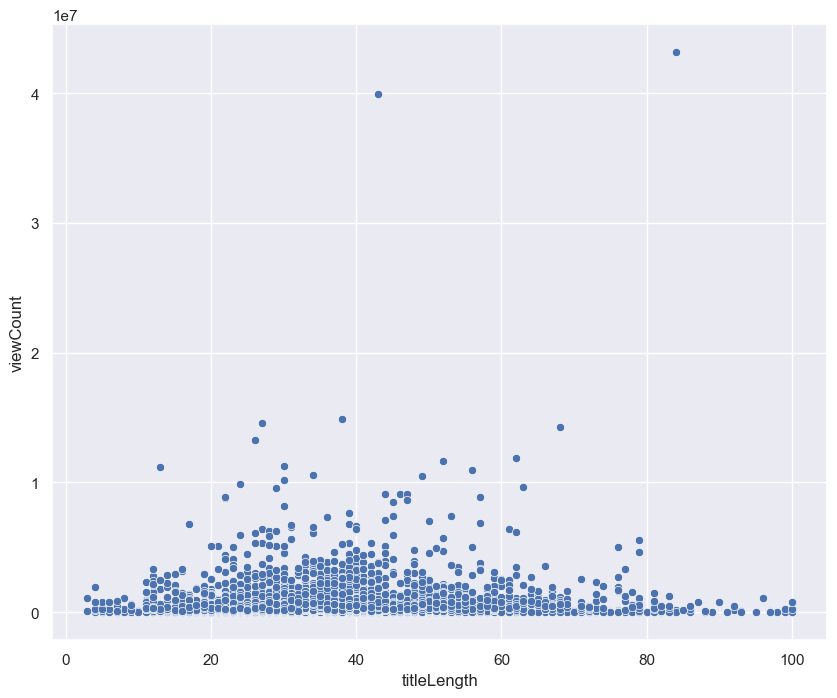

In [33]:
sns.scatterplot(data = video_df, x = "titleLength", y = "viewCount")

### Wordcloud for words in title

As I'm interested to see what the creators are making videos about and which terms most frequently appear in their video titles, I will create a wordcloud for the most common words.

In [30]:
stop_words = set(stopwords.words('indonesian'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

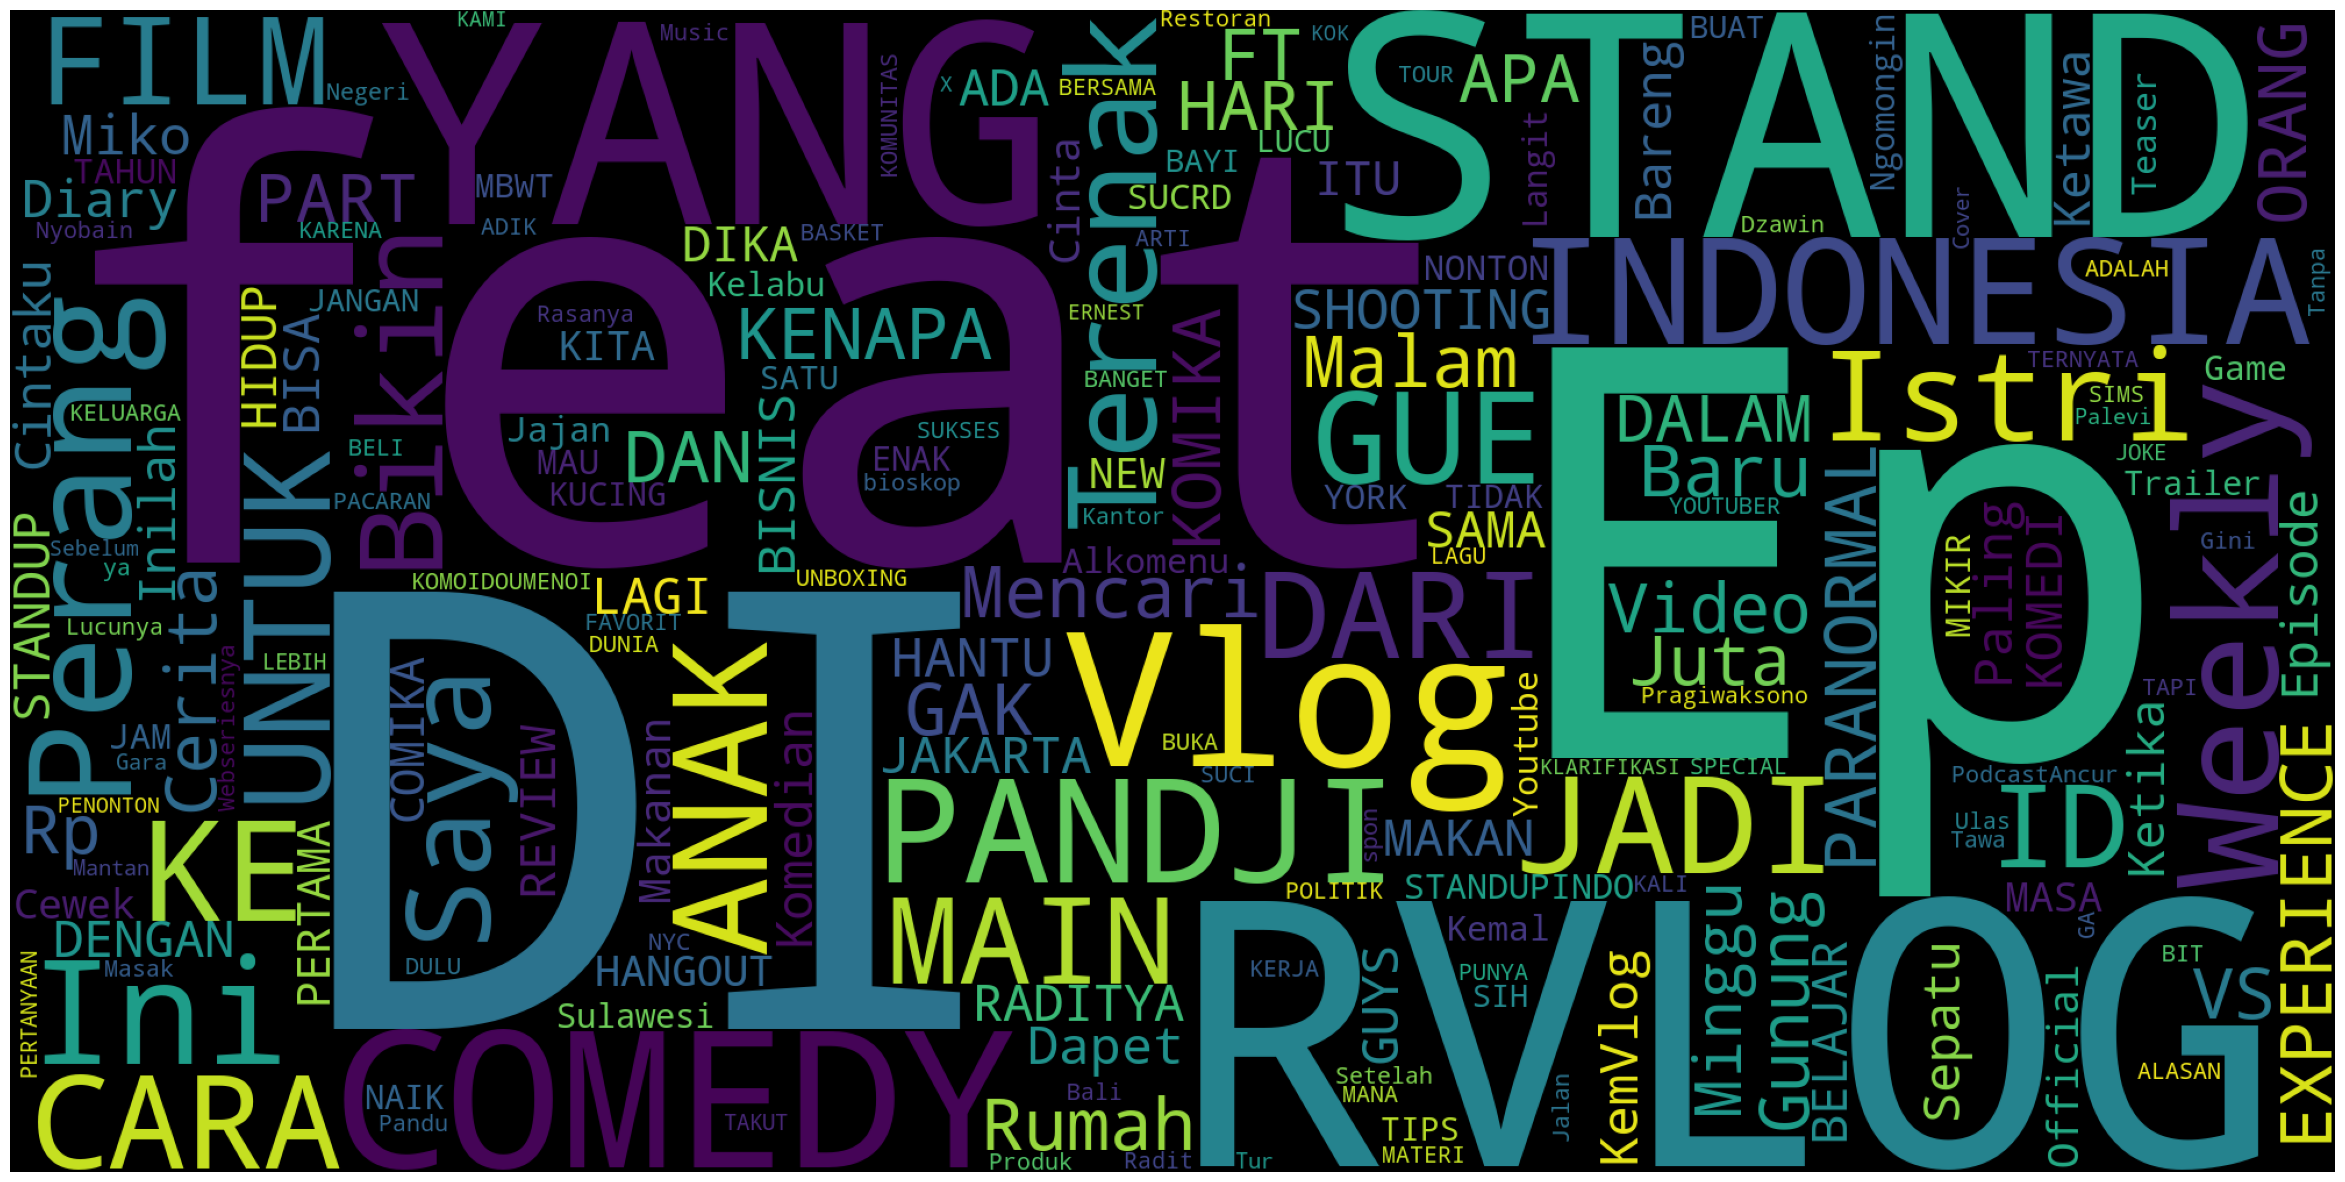

In [31]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

### Number of tags vs views

It seems that most videos have between 5 and 25 tags. The relationship between number of tags and view count is not clearly seen, but too few tags or too many tags do seem to correlate with fewer views.

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='tagsCount', ylabel='viewCount'>

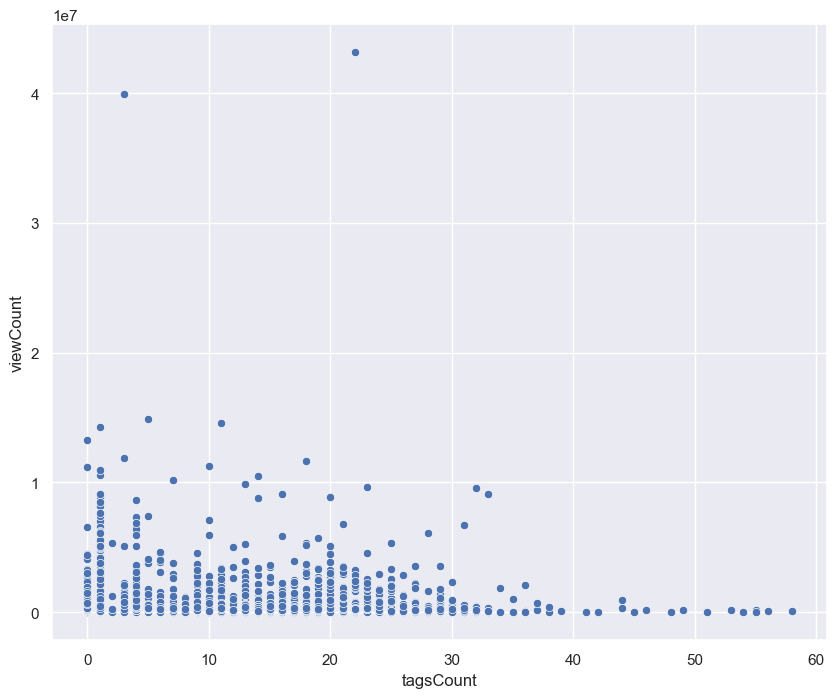

In [32]:
sns.scatterplot(data = video_df, x = "tagsCount", y = "viewCount")

### Which day in the week are most videos uploaded?


It's interesting to see that more videos are uploaded on Mondays. This could be due to several factors. For example, content creators may choose to upload videos on Mondays to kickstart the week and capture the audience's attention early in the workweek. Additionally, viewers might be more active and engaged with online content at the beginning of the week, leading creators to schedule their uploads accordingly.

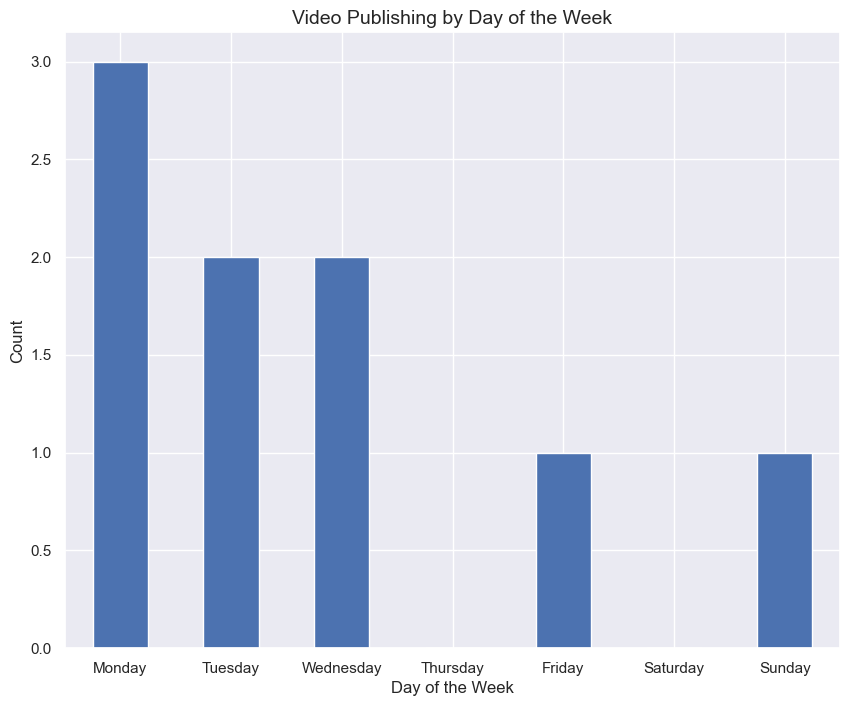

In [35]:
data = {'publishedDayName': ["Monday", "Tuesday", "Monday", "Wednesday", "Friday", "Sunday", "Monday", "Tuesday", "Wednesday"]}
video_df = pd.DataFrame(data)

day_df = pd.DataFrame(video_df['publishedDayName'].value_counts().reindex(weekdays, fill_value=0))
day_df = day_df.reset_index()
day_df.columns = ['Day', 'Count']
ax = day_df.plot.bar(x='Day', y='Count', legend=False)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Video Publishing by Day of the Week', fontsize=14)
plt.show()

### Wordcloud for video comments

We can see what are the frequently-mentioned words in the video comments. I will do this by visualizing the keywords in a wordcloud.

In [36]:
stop_words = set(stopwords.words('english'))
comments_df['comments_no_stopwords'] = comments_df['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

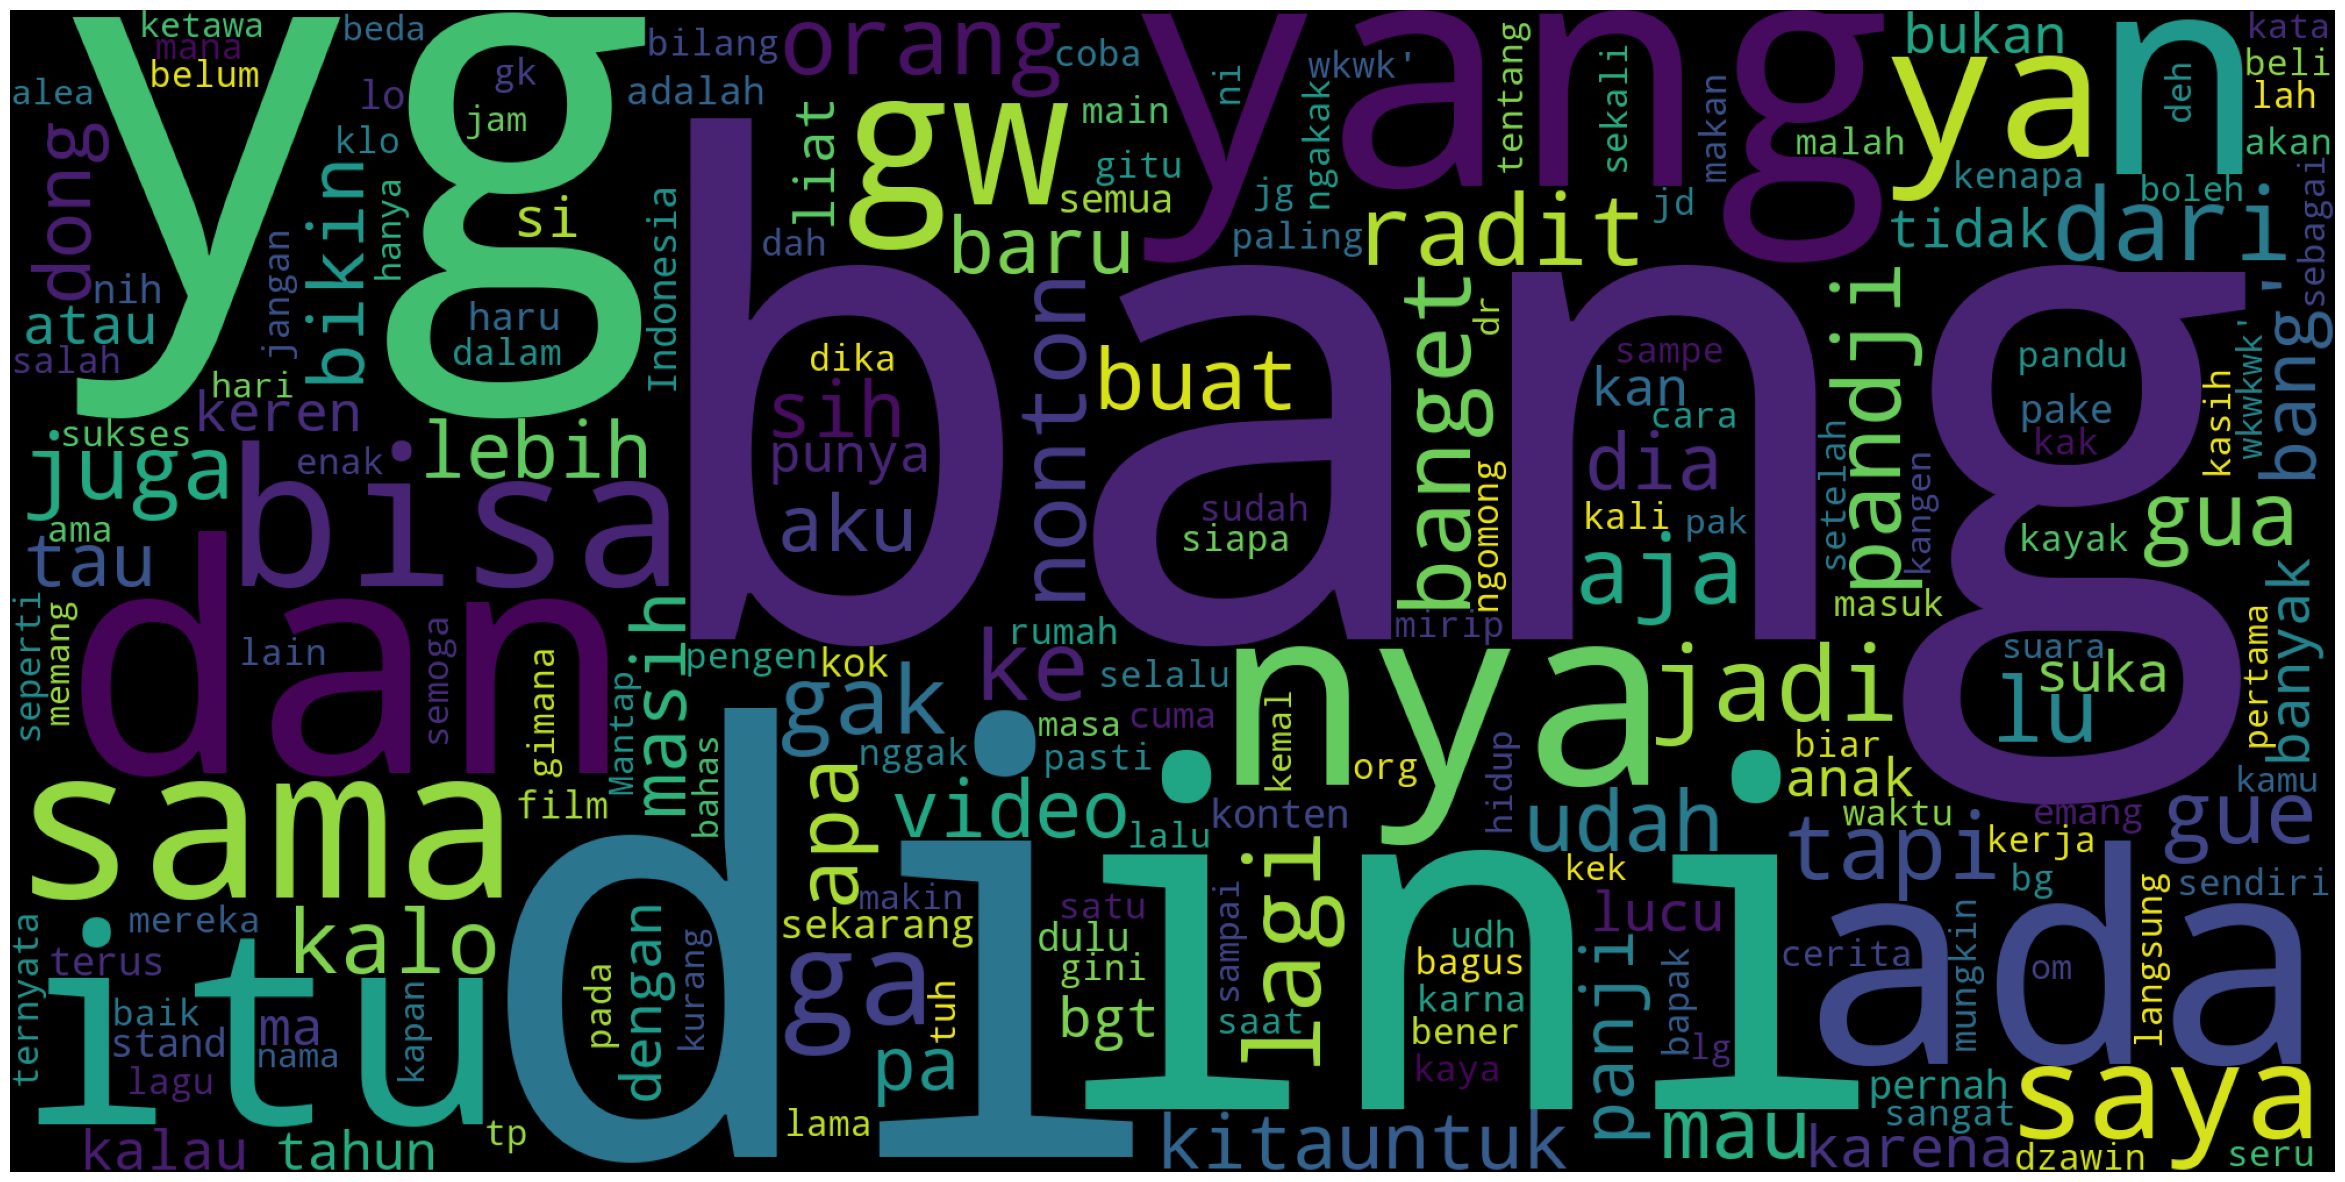

In [37]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)